In [44]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots

In [ ]:
# para entrenar
X_t0 = pd.read_parquet('X_t0.parquet')
y_t0 = pd.read_parquet('y_t0.parquet')
# para predecir(?)
X_t1 = pd.read_parquet('X_t1.parquet')

In [9]:
X_t0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44296 entries, 0 to 44295
Data columns (total 77 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   borrow_block_number                      44296 non-null  int64  
 1   borrow_timestamp                         44296 non-null  float64
 2   wallet_address                           44296 non-null  object 
 3   first_tx_timestamp                       44296 non-null  float64
 4   last_tx_timestamp                        44296 non-null  float64
 5   wallet_age                               44296 non-null  float64
 6   incoming_tx_count                        44296 non-null  int64  
 7   outgoing_tx_count                        44296 non-null  int64  
 8   net_incoming_tx_count                    44296 non-null  int64  
 9   total_gas_paid_eth                       44296 non-null  float64
 10  avg_gas_paid_per_tx_eth                  44296

In [37]:
numeric_var = X_t0.select_dtypes(include=['number']).columns
object_var = X_t0.select_dtypes(include=['object']).columns

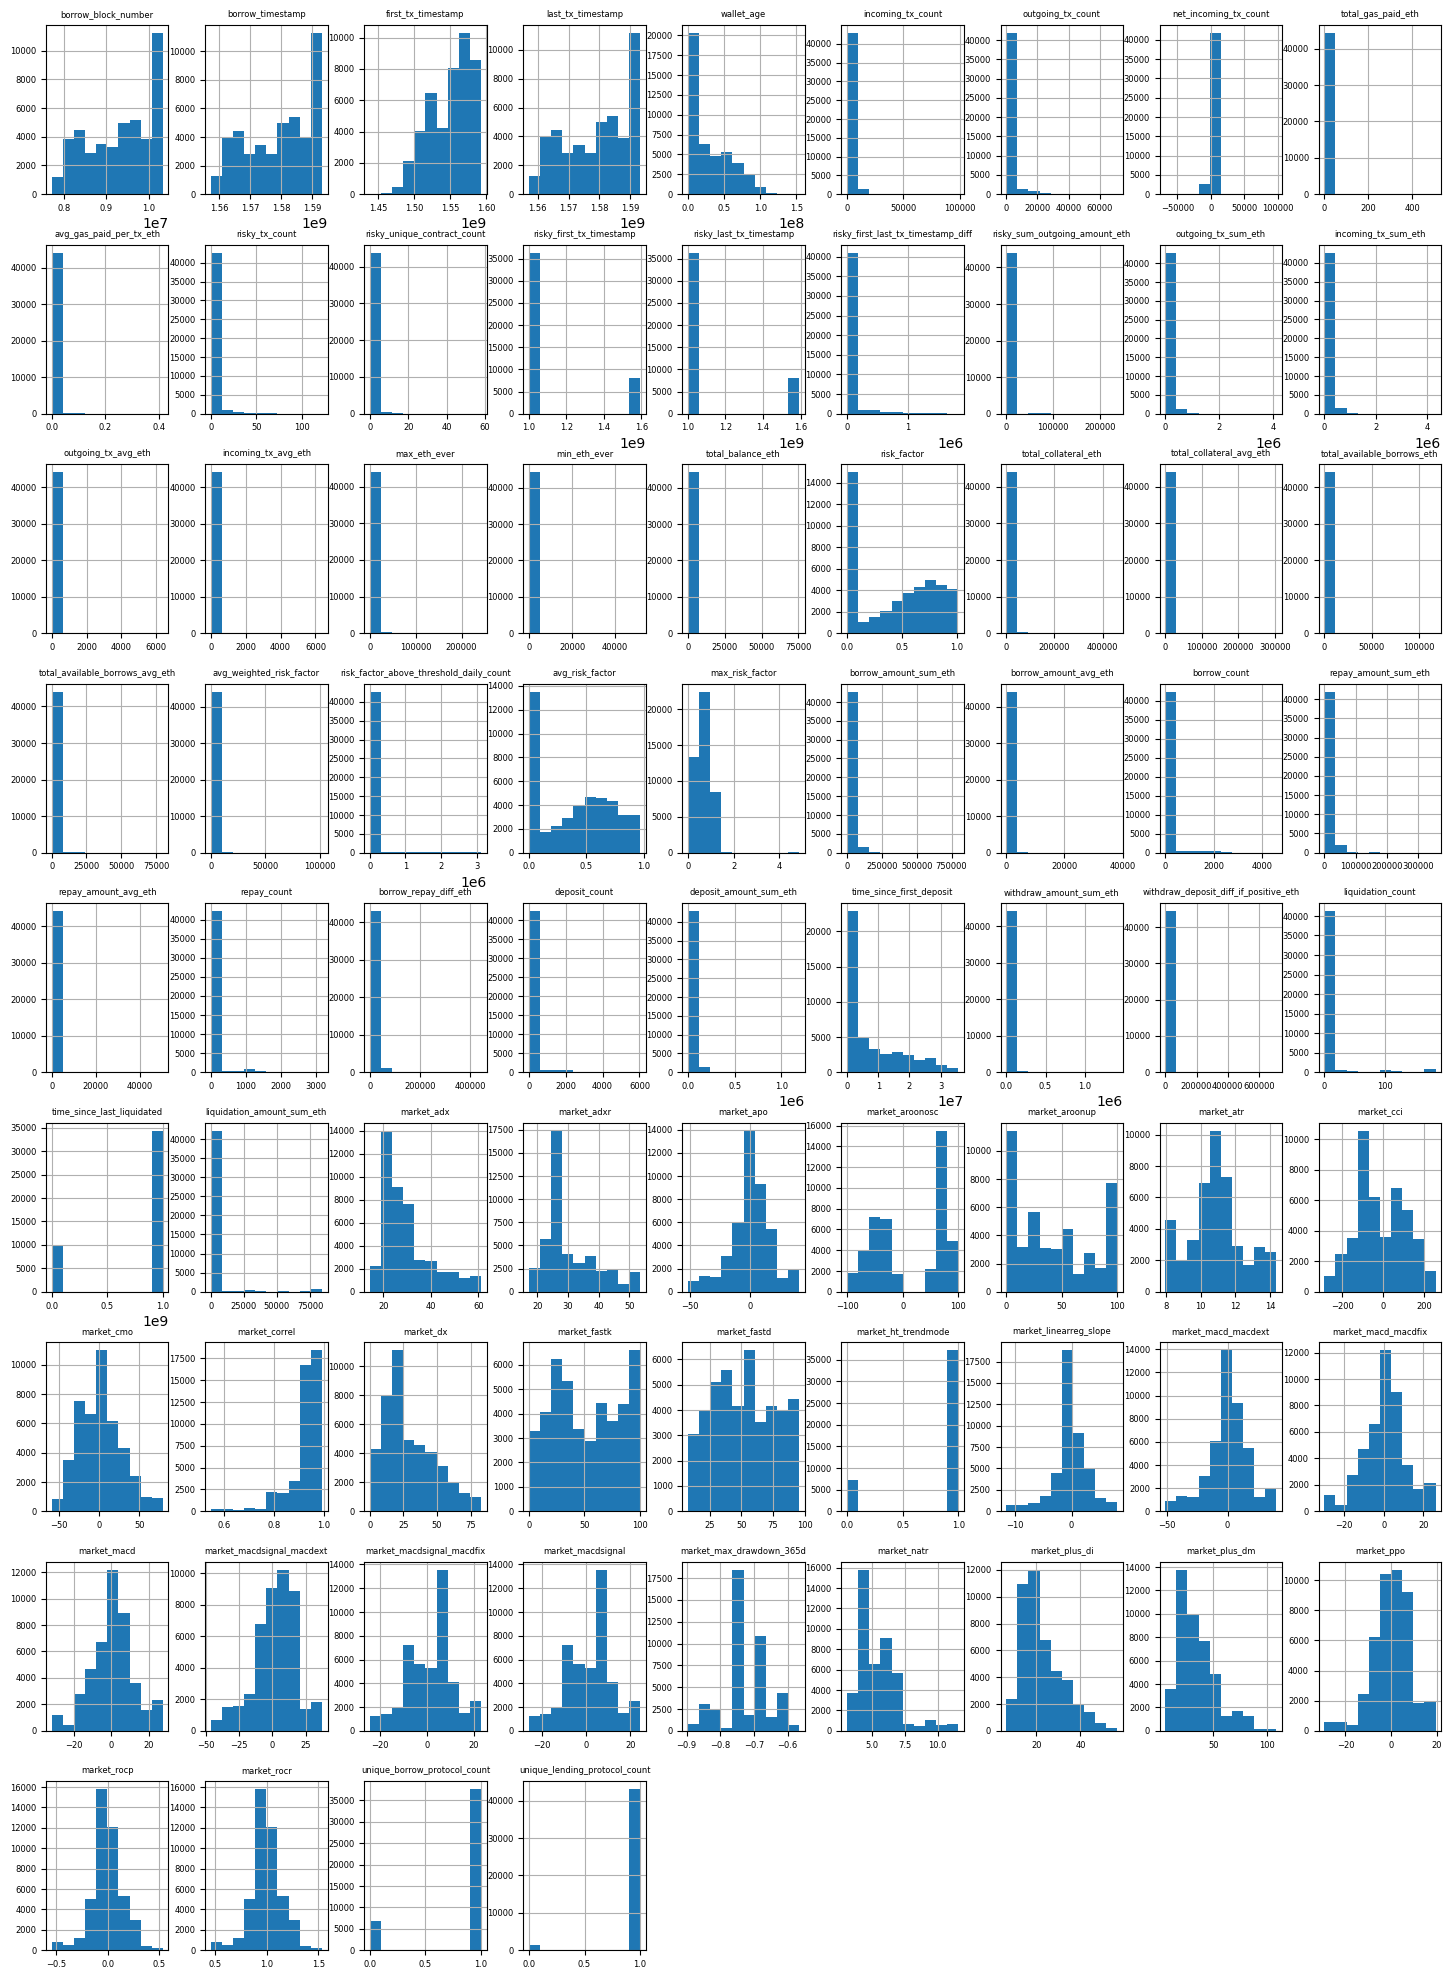

In [ ]:
# Histogramas para revisar el comportamiento de las variables
axes = X_t0.hist(figsize=(18,25))

for ax in axes.flatten():
    ax.set_title(ax.get_title(), fontsize=6)
    ax.tick_params(axis='x', labelsize=6)
    ax.tick_params(axis='y', labelsize=6)

In [47]:
X_corr = X_t0[numeric_var].corr()

fig = go.Figure()
fig.add_trace(
    go.Heatmap(
        x = X_corr.columns,
        y = X_corr.index,
        z = np.array(X_corr),
        text=X_corr.values,
        texttemplate='%{text:.2f}'
    )
)
fig.update_layout(title_text='Correlación entre las variables numéricas',
                    height=800, width=1400)
fig.show()